In [0]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
data_dir = "drive/My Drive/CIL/data"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda")
batch_size = 64
size = (224, 224)
image_dir = "scored_512"
test_image_dir = "query_512"
collab = True

In [5]:
if collab:
  from google.colab import drive
  drive.mount('/content/drive')

  zip_path = data_dir + '/scored_512.zip'
  !cp '{zip_path}' .
  !unzip -q scored_512.zip
  !rm scored_512.zip
  zip_path = data_dir + '/query_512.zip'
  !cp '{zip_path}' .
  !unzip -q query_512.zip
  !rm query_512.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
scores = pd.read_csv(data_dir + "/scored.csv", index_col="Id")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80d51f8d30>]],
      dtype=object)

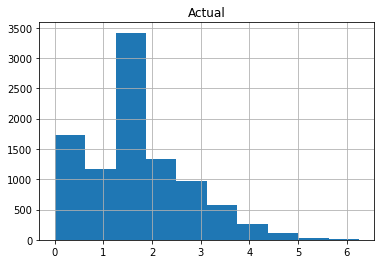

In [7]:
scores.hist()

In [0]:
class GalaxyDataset(torch.utils.data.Dataset):
    """Galaxy dataset."""

    def __init__(self, csv_file, image_dir, transform=None, mode='train', size=(128, 128), train_split=0.85):
        if mode is "test":
          self.Ids = []
        else:
          self.scores = pd.read_csv(csv_file, index_col="Id")

        self.size = size
        self.samples = []
        self.mode = mode
        if mode == 'train':
          self.scores = self.scores[:int(self.scores.shape[0]*train_split)]
        elif mode == 'val':
          self.scores = self.scores[int(self.scores.shape[0]*train_split):]
        self.image_dir = image_dir
        self.transform = transform

        self.load_dataset()
    def __len__(self):
        return len(self.samples)

    def load_dataset(self):
      print("Loading Dataset...")
      if self.mode == 'test':
        for img_name in os.listdir(self.image_dir):
          if img_name[-3:] == 'png':
            self.samples.append(Image.open(os.path.join(self.image_dir, img_name)).resize(self.size))
            self.Ids.append(img_name[:-4])
      else:
        for id, _ in self.scores.iterrows():
          img_name = os.path.join(self.image_dir,
                                    str(id)+'.png')
          self.samples.append(Image.open(img_name).resize(self.size))
      print("Dataset Loaded")

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.samples[idx]
        if self.mode == 'test':
          return self.transform(image)

        scores = self.scores.iloc[idx]['Actual']
        scores = (scores / 4.0) - 1
        if self.transform is not None:
            image = self.transform(image)

        return (image, scores)

In [0]:
train_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.RandomAffine(30, translate=(0.2, 0.2)),
                            torchvision.transforms.ToTensor()
])
val_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
])
test_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
])

In [0]:
train_dataset = GalaxyDataset(data_dir + "/scored.csv", image_dir, transform=train_transformation, mode='train', size=size)
val_dataset = GalaxyDataset(data_dir + "/scored.csv", image_dir, transform=val_transformation, mode='val', size=size)
test_dataset = GalaxyDataset("", test_image_dir, transform=val_transformation, mode='test', size=size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)

Loading Dataset...


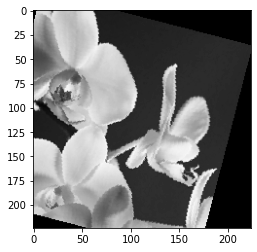

In [0]:
plt.imshow(train_dataset[23][0].numpy().squeeze(), cmap="gray", vmin=0, vmax=1)

In [0]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
with torch.no_grad():
  weights = model.conv1.weight
  model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model.conv1.weight = torch.nn.Parameter(weights.sum(axis=1, keepdim=True))
  model.fc = nn.Linear(512, 1)
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
class Scorer(nn.Module):
    def __init__(self):
        super(Scorer, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv1_1 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.conv4_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        # self.conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        # self.conv5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        # self.conv6 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
        # self.conv6_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(16*16*256, 4096)
        self.fc2 = nn.Linear(4096, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        # x = F.relu(self.conv5(x))
        # x = F.relu(self.conv5_1(x))
        # x = F.relu(self.conv6(x))
        # x = F.relu(self.conv6_1(x))
        x = x.view(-1, 16*16*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Scorer().to(device)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.L1Loss(reduction='mean')
val_loss = torch.nn.L1Loss(reduction='mean')
best_val_score = 1
epochs = 100

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output.squeeze(), target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [0]:
def val(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data = data.to(device)
            target = target.float().to(device)
            output = model(data)
            test_loss += val_loss(output.squeeze(), target).item()

    test_loss /= len(val_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss

In [0]:
for epoch in range(0, epochs + 1):
    train(epoch)
    test_loss = val(epoch)
    if test_loss < best_val_score:
      best_val_score = test_loss
      torch.save(model.state_dict(), "scorer.model")

Train Epoch: 0 [0/8160 (0%)]	Loss: 0.006360
Train Epoch: 0 [320/8160 (4%)]	Loss: 0.003709
Train Epoch: 0 [640/8160 (8%)]	Loss: 0.003253
Train Epoch: 0 [960/8160 (12%)]	Loss: 0.003438
Train Epoch: 0 [1280/8160 (16%)]	Loss: 0.003176
Train Epoch: 0 [1600/8160 (20%)]	Loss: 0.004282
Train Epoch: 0 [1920/8160 (23%)]	Loss: 0.003110
Train Epoch: 0 [2240/8160 (27%)]	Loss: 0.002636
Train Epoch: 0 [2560/8160 (31%)]	Loss: 0.003077
Train Epoch: 0 [2880/8160 (35%)]	Loss: 0.002498
Train Epoch: 0 [3200/8160 (39%)]	Loss: 0.003040
Train Epoch: 0 [3520/8160 (43%)]	Loss: 0.002569
Train Epoch: 0 [3840/8160 (47%)]	Loss: 0.002262
Train Epoch: 0 [4160/8160 (51%)]	Loss: 0.003154
Train Epoch: 0 [4480/8160 (55%)]	Loss: 0.003208
Train Epoch: 0 [4800/8160 (59%)]	Loss: 0.002848
Train Epoch: 0 [5120/8160 (62%)]	Loss: 0.002323
Train Epoch: 0 [5440/8160 (66%)]	Loss: 0.002573
Train Epoch: 0 [5760/8160 (70%)]	Loss: 0.002298
Train Epoch: 0 [6080/8160 (74%)]	Loss: 0.002596
Train Epoch: 0 [6400/8160 (78%)]	Loss: 0.002610
T

In [0]:
preds = np.zeros(len(test_dataset))
for i, (data) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            output = (output + 1) * 4
            output = torch.clamp(output, 0, 8)
            preds[i*batch_size:i*batch_size + data.shape[0]] = output.cpu().detach().numpy().squeeze()

In [0]:
print(preds.max())
preds.min()

3.461047410964966


0.0

In [0]:
data = np.hstack((np.asarray(test_dataset.Ids).reshape(-1, 1), preds.reshape(-1, 1)))
res = pd.DataFrame(columns=["Id", "Predicted"], data=data)
res.to_csv("res.csv", index=False)

In [0]:
!cp scorer.model '{data_dir}'

In [0]:
torch.save(model.state_dict(), data_dir + "/scorer.model")

OSError: ignored